<a href="https://colab.research.google.com/github/nikizadehgfdl/thin-wall-topography/blob/master/python/algorithm_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is for developement and testing of algorithm for the thin wall topography

Some helper functions

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Helper functions

def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r',alpha=1.0):
    #mesh plot
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color, alpha=alpha)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color, alpha=alpha)
    

def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r'):
    #mesh plot
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color)

def generate_rect_test_grid(lon0,lonlen,ni,lat0,latlen,nj):
    #generate a simple rectilinear grid
    lon = lon0 + np.arange(ni+1) * lonlen/ni
    lat = lat0 + np.arange(nj+1) * latlen/nj
    lon_grid = np.tile(lon, (nj+1,1)) 
    lat_grid = np.tile(lat.reshape(nj+1,1), (1,ni+1))
    return lon_grid,lat_grid
  
def generate_rect_test_mesh(lon0,lonlen,ni,lat0,latlen,nj):
    #generate a simple rectilinear grid
    lon = lon0 + np.arange(ni+1) * lonlen/ni
    lat = lat0 + np.arange(nj+1) * latlen/nj
    lonlatmesh=np.meshgrid(lon,lat)
    return lonlatmesh
  


#simple refining function. might be too slow
def refineby2(x2d):
    x_rf2 = np.zeros([x2d.shape[0]*2-1 , x2d.shape[1]*2-1])
    for j,l in enumerate(x2d):
        for i,aji in enumerate(l):
            x_rf2[2*j,2*i] = x2d[j,i]
            if(j<x2d.shape[0]-1):
                x_rf2[2*j+1,2*i] = (x2d[j,i]+x2d[j+1,i])/2
            if(i<x2d.shape[1]-1):   
                x_rf2[2*j,2*i+1] = (x2d[j,i]+x2d[j,i+1])/2
            if(j<x2d.shape[0]-1 and i<x2d.shape[1]-1):    
                x_rf2[2*j+1,2*i+2] = (x2d[j,i+1]+x2d[j+1,i+1])/2
                x_rf2[2*j+2,2*i+1] = (x2d[j+1,i]+x2d[j+1,i+1])/2
                x_rf2[2*j+1,2*i+1] = (x2d[j,i]+x2d[j,i+1]+x2d[j+1,i]+x2d[j+1,i+1])/4
    return x_rf2

    

## Developing a refining algorithm

Actual source data like GEBCO (further below) are too large for devloping/tesing. Here we use simple small recitilinear grids to start with.

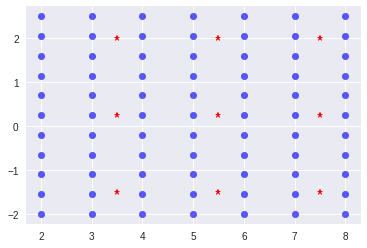

In [10]:
#Let's start with some small rectilinear grids for testing
#source grid 
src_lon_grid,src_lat_grid = generate_rect_test_grid(2,6,6,-2,4.5,10)
#The following seems to be equivalent to the above call
#src_lon_grid,src_lat_grid = generate_rect_test_mesh(2,6,6,-2,4.5,10)
#print(src_lon_grid.shape,src_lat_grid.shape)
#target grid
trg_lon_grid,trg_lat_grid = generate_rect_test_grid(3.5,4,2,-1.5,3.5,2)
#print(trg_lon_grid.shape,trg_lat_grid.shape)
#plt.figure(figsize=(10,10))
plot_mesh_in_latlon(src_lon_grid, src_lat_grid, phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(trg_lon_grid, trg_lat_grid, phi_color='r*', lam_color='r*')

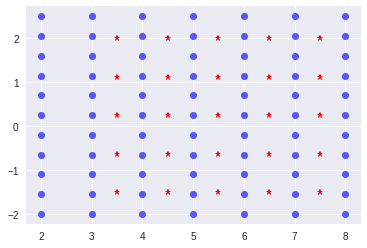

In [11]:
#refine once
lon_rf2=refineby2(trg_lon_grid)
lat_rf2=refineby2(trg_lat_grid)
#plt.figure(figsize=(10,10))
plot_mesh_in_latlon(src_lon_grid, src_lat_grid, phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(lon_rf2, lat_rf2, phi_color='r*', lam_color='r*')

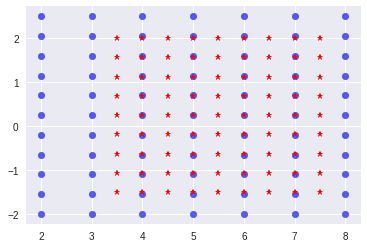

In [29]:
#refine twice
lon_rf4=refineby2(lon_rf2)
lat_rf4=refineby2(lat_rf2)
#plt.figure(figsize=(10,10))
plot_mesh_in_latlon(src_lon_grid, src_lat_grid, phi_color='bo', lam_color='bo',alpha=0.4)
plot_mesh_in_latlon(lon_rf4, lat_rf4, phi_color='r*', lam_color='r*')

The above example shows that after two refining steps (by factors of 2) each refined cell is "smaller" than its 6 neigboring source grid cells. How do we diagnose this in general? 

Is a refined cell always surronded by 6 source cells (for any given grids)? 

Also note that in this example there are many refined grid points that are equidistant from two distinct source points which in general have different depth values. Do we average the two values in such cases? 

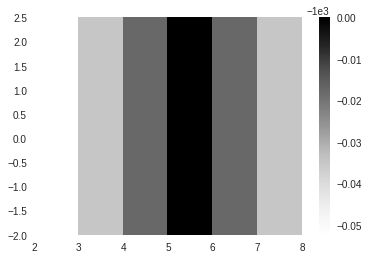

In [25]:
#generate a fake source topography with a ridge in the middle
PI_180=np.pi/180
src_depth = -1000 - np.abs(np.sin((src_lon_grid-5) *PI_180))
plt.pcolormesh(src_lon_grid,src_lat_grid,src_depth); plt.colorbar();

/usr/local/lib/python3.6/dist-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=10,12 m=77 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


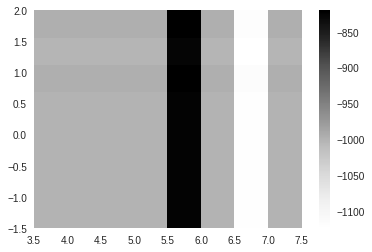

In [30]:
#interpolate the source topog to the refined grid
#using scipy
from scipy import interpolate
f_interp = interpolate.interp2d(src_lon_grid,src_lat_grid,src_depth,kind='linear')
depth_rf4_scipy = f_interp(lon_rf4[0,:], lat_rf4[:,0])
plt.pcolormesh(lon_rf4, lat_rf4, depth_rf4_scipy); plt.colorbar();

sciipy.interpolate does not seem to be doing right

## GEBCO  1 minute by 1 minute dataset

In [0]:
import netCDF4

gebcodata = netCDF4.Dataset('/home/niki/gfdlprojects/thin-wall-topography/work/GRIDONE_2D.nc')
#for var in gebcodata.variables :  print(var,end=' ')
#Note that the variables are arrays but they are not numpy arrays. 
#Convert them to numpy using np.array so that they can be reshaped.
gebco_lon = np.array(gebcodata.variables['lon'])
gebco_lat = np.array(gebcodata.variables['lat'])
gebco_elv = np.array(gebcodata.variables['elevation'])

gebco_lon_grd = np.tile(gebco_lon,(10801,1))
gebco_lat_grd = np.tile(gebco_lat.reshape(10801,1),(1,21601))
print('source grid array shapes: ' , gebco_lon_grd.shape,gebco_lat_grd.shape,gebco_elv.shape)
print('source grid nominal resolution : ',gebco_lon[10801]-gebco_lon[10800],gebco_lat[5401]-gebco_lat[5400] )

source grid array shapes:  (10801, 21601) (10801, 21601) (10801, 21601)
source grid nominal resolution :  0.0166666666667 0.0166666666667


In [0]:
0.0166666666667 * 60

1.000000000002

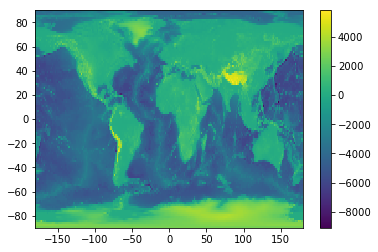

In [0]:
#Data arrays are too large to plot and my machine runs out of memory
plt.pcolormesh(gebco_lon_grd[::100,::100], gebco_lat_grd[::100,::100],gebco_elv[::100,::100]);plt.colorbar()

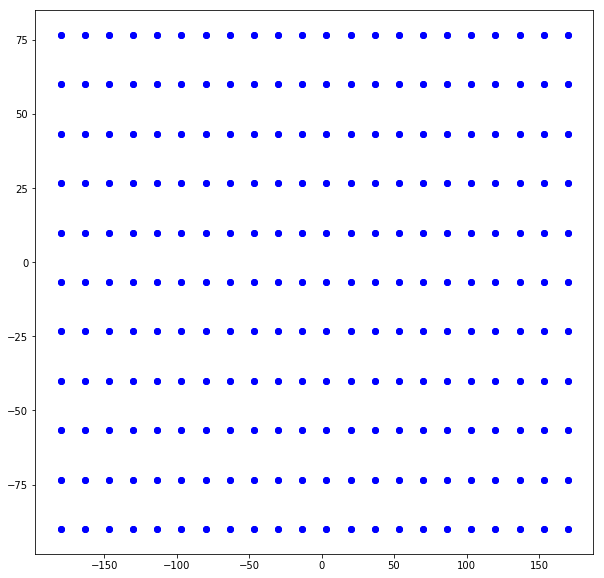

In [0]:
#Data arrays are too large to plot and my machine runs out of memory
plt.figure(figsize=(10,10))
plot_mesh_in_latlon(gebco_lon_grd[::1000,::1000], gebco_lat_grd[::1000,::1000], phi_color='bo', lam_color='bo')

In [0]:
#It is not clear what .zoom does, but is not doing what we want!
import scipy.ndimage
lonz = scipy.ndimage.zoom(trg_lon_grid,2,order=1)
#latz = scipy.ndimage.zoom(trg_lat_grid,2,order=1)
print (trg_lon_grid)
print (lonz)

[[ 2.5         4.66666667  6.83333333  9.        ]
 [ 2.5         4.66666667  6.83333333  9.        ]
 [ 2.5         4.66666667  6.83333333  9.        ]
 [ 2.5         4.66666667  6.83333333  9.        ]
 [ 2.5         4.66666667  6.83333333  9.        ]]
[[ 2.5         3.42857143  4.35714286  5.28571429  6.21428571  7.14285714
   8.07142857  9.        ]
 [ 2.5         3.42857143  4.35714286  5.28571429  6.21428571  7.14285714
   8.07142857  9.        ]
 [ 2.5         3.42857143  4.35714286  5.28571429  6.21428571  7.14285714
   8.07142857  9.        ]
 [ 2.5         3.42857143  4.35714286  5.28571429  6.21428571  7.14285714
   8.07142857  9.        ]
 [ 2.5         3.42857143  4.35714286  5.28571429  6.21428571  7.14285714
   8.07142857  9.        ]
 [ 2.5         3.42857143  4.35714286  5.28571429  6.21428571  7.14285714
   8.07142857  9.        ]
 [ 2.5         3.42857143  4.35714286  5.28571429  6.21428571  7.14285714
   8.07142857  9.        ]
 [ 2.5         3.42857143  4.35714286